In [83]:
import pandas as pd
import torch
import numpy as np
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
train = pd.read_csv("../data/heart_train.csv")
val = pd.read_csv("../data/heart_val.csv")
test = pd.read_csv("../data/heart_test.csv")
anomaly = pd.read_csv("../data/heart_anomaly.csv")

In [59]:
train = train.drop(labels = "Unnamed: 0", axis=1)
val = val.drop(labels = "Unnamed: 0", axis=1)
test = test.drop(labels = "Unnamed: 0", axis=1)
anomaly = anomaly.drop(labels = "Unnamed: 0", axis=1)

In [60]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [61]:
train_dataset, seq_len, n_features = create_dataset(train)
val_dataset, _, _ = create_dataset(val)
test_normal_dataset, _, _ = create_dataset(test)
test_anomaly_dataset, _, _ = create_dataset(anomaly)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)
    
class RecurrentAutoencoder(nn.Module):
 
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [63]:
model = torch.load('../data/heart_model.pth', map_location ='cpu')
model.to(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [64]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

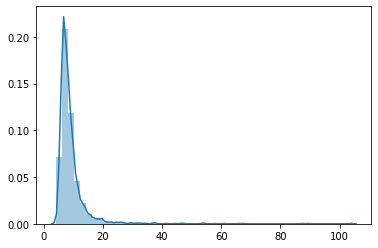

In [66]:
_, losses = predict(model, train_dataset)

In [74]:
THR = 20

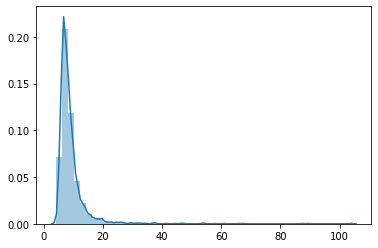

In [71]:
sns.distplot(losses, bins=50, kde=True);

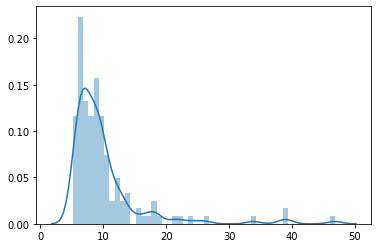

In [72]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [75]:
correct = sum(l <= THR for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 137/145


In [76]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

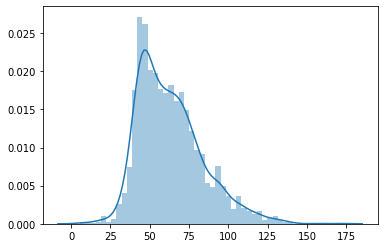

In [98]:
predictions, pred_losses = predict(model, test_anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [100]:
correct = sum(l > THR for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

Correct anomaly predictions: 2073/2081


In [90]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

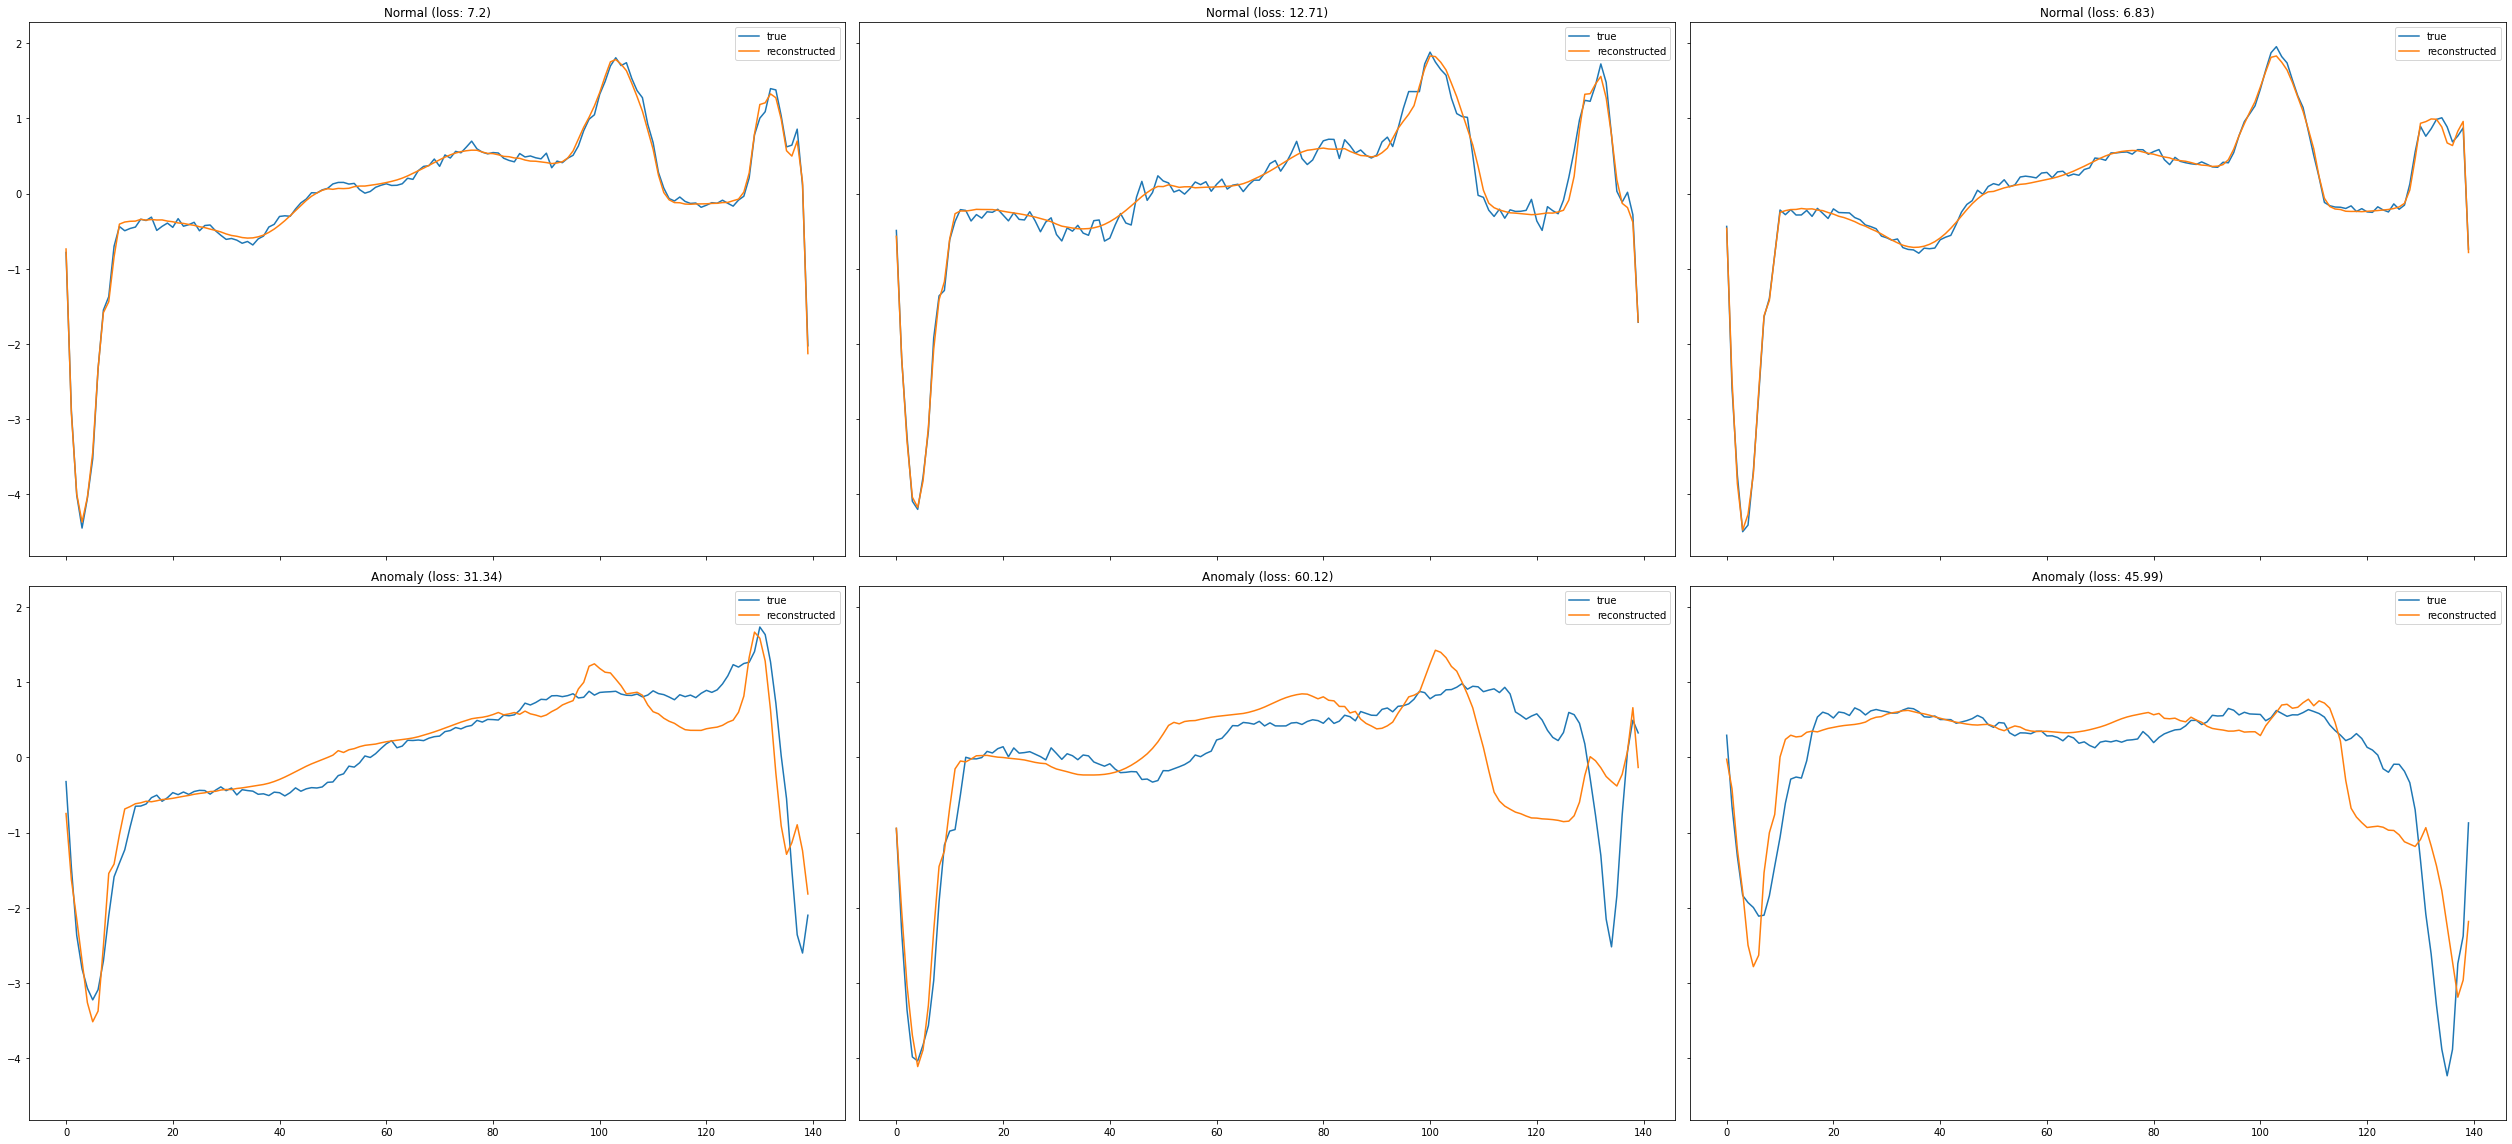

In [102]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(35, 16),
)

for i, data in enumerate(test_normal_dataset[:3]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();